In [16]:
! pip install --quiet pymongo[srv,tls] 
# ! pip install --quiet pystan

In [17]:
from pymongo import MongoClient
from dateutil.parser import parse
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels.api as sm
from scipy.stats import mannwhitneyu, f_oneway
import os

In [18]:
client = MongoClient(os.environ.get('MONGO_HOST'), 
            username = os.environ.get('MONGO_USER'), 
                     password = os.environ.get('MONGO_PASS'))
coll = client['mab-survey'].trial

In [19]:
def get_avg_interval(boxes):
    times = [parse(b['timestamp']) for b in boxes]
    return np.mean(np.diff(times)).seconds
    
def get_spread(d): 
    boxes = d['boxes'][1]
    return parse(boxes[-1]['timestamp']) - parse(boxes[0]['timestamp'])

won = lambda b: len([i for i in b if i['result'] == 'win']) > 0

In [20]:
l = list(coll.find({ 'version': '0.5'}))

In [39]:
from scipy.stats import beta

w = [won(i['boxes'][1]) for i in l]
t = [i['treatment']['ab'] for i in l]
time = [get_spread(d).total_seconds() for d in l]
rolls = [len(d['boxes'][1]) for d in l]
avg = [get_avg_interval(i['boxes'][1]) for i in l]

df = pd.DataFrame({
    'won': w,
    'treatment': t,
    'time': time,
    'rolls': rolls,
    'roll_time': avg
})



prize = 500
posterior = lambda n: beta.mean(1,1 + n)
# c = lambda rho: lambda p: p**(1/(1-rho)) * prize
c = lambda rho: lambda p: (p * (prize + 1)**(1-rho) - p + 1)**(1/(1-rho))

def marginal(alpha = 1, prev = 500):
    return lambda c: 1 - np.exp(-alpha * (prev + c))


def c(rho, prize = 5, base = 100):
    u = lambda c: (c**(1 - rho) - 1)/(1 - rho)
    def marginal(p):
        a = p * u(prize + base) + (1 - p) * u(base)
        return (a * (1-rho) + 1)**(1/(1-rho)) - base
    return marginal

# c = lambda rho: lambda p: prize**p
# opportunity cost per second
# (5p - p + 1)/rolltime
# vs -- that +1 messes it up!
# p*5/roll_time


# df['opportunity_cost'] = df.rolls.map(posterior).map(c(2.)) / df.roll_time
df['opportunity_cost'] = df.rolls.map(posterior).map(c(2.)) / df.roll_time
df['opportunity_cost_log'] = df.rolls.map(posterior).map(c(1.001)) / df.roll_time
# df['opportunity_cost_log'] = df.rolls.map(posterior).map(lambda p: (prize + 1)**p) / df.roll_time - 1/df.roll_time
# df['opportunity_cost_linear'] = df.rolls.map(posterior).map(lambda p: p*prize + 1 - p) / df.roll_time 
# df['opportunity_cost_linear'] = df.rolls.map(posterior) * prize / df.roll_time - (1 - 1/df.roll_time) - 1
df['opportunity_cost_linear'] = df.rolls.map(posterior) * prize/ df.roll_time


df = df.assign(group = (df.treatment == 'a').astype(int) + 1)
df = df.assign(prize = prize )

(_,a),(_,b) = df[df.won == False].groupby('treatment')

d = df[df.won == False]

d.head()

   roll_time  rolls     time treatment    won  opportunity_cost  \
0         16      6   82.304         b  False          0.037425   
1         13      7   82.119         b  False          0.040917   
2          3     21   74.603         a  False          0.069156   
3          5     53  307.298         a  False          0.017331   
6         14     28  393.371         b  False          0.011356   

   opportunity_cost_log  opportunity_cost_linear  group  prize  
0              0.038233                 3.906250      1    500  
1              0.041813                 4.273504      1    500  
2              0.070784                 7.246377      2    500  
3              0.017749                 1.818182      2    500  
6              0.011626                 1.190476      1    500  

In [48]:
np.log(5)*.05, np.log(1.05)

(0.080471895621705022, 0.048790164169432049)

In [ ]:
d.to_csv('distortion.csv')

In [3]:
d = pd.read_csv('./distortion.csv')

In [28]:
prize = 5
posterior = lambda n: beta.mean(1,1 + n)
c = lambda rho: lambda p: p**(1/(1-rho)) * prize

d['opportunity_cost'] = d.rolls.map(posterior).map(c(1.02)) / d.roll_time

(_,a),(_,b) = d[d.won == False].groupby('treatment')

In [4]:
# eps_all = pd.read_csv('eps.all.csv')
means = pd.read_csv('eps_sampled3.csv')
means = means.rename(columns = {'mean_epsilon.1': 'B', 'mean_epsilon.2': 'A'})

In [9]:
(np.median(means.A) - np.median(means.B)) / np.median(means.B)

0.55593037418485969

In [11]:
def post_anova(N):
    a = np.random.choice(means.A, N)
    b = np.random.choice(means.B, N)
    return ((b - a) > 0).sum()/N

post_anova(1000000)

0.0089859999999999992

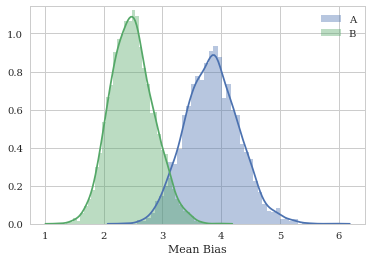

In [14]:
import matplotlib.pyplot as plt

sns.set(font = 'serif', style = 'whitegrid')
sns.distplot(means.A, label = 'A')
sns.distplot(means.B, label = 'B')
plt.xlabel('Mean Bias')
plt.legend()
plt.savefig('mean-bias.pdf')
plt.show()

In [ ]:
eps_all.drop(['Unnamed: 0'], 1).iloc[:, (d.treatment == 'a').tolist()].plot.hist(bins = 30)

In [ ]:
eps_all.drop(['Unnamed: 0'], 1).iloc[:, (d.treatment == 'b').tolist()].plot.hist(bins = 30)

In [29]:
from statsmodels.iolib.summary2 import _df_to_simpletable

In [40]:
f = (pd
     .concat([d.groupby('treatment').median(), d.groupby('treatment').mean()])
     .reset_index())

f.insert(1, 'N', [29, 28, 29, 28])
f = f.drop(['group', 'prize', 'won'], 1)

f

  treatment   N  roll_time      rolls        time  opportunity_cost  \
0         a  29   4.000000  54.000000  239.907000          0.020362   
1         b  28  15.000000  18.000000  311.389000          0.013790   
2         a  29   4.517241  76.724138  374.412828          0.034801   
3         b  28  16.892857  23.714286  400.077000          0.019975   

   opportunity_cost_log  opportunity_cost_linear  
0              0.020857                 2.136752  
1              0.014114                 1.444847  
2              0.035613                 3.644960  
3              0.020419                 2.087507  

In [47]:
print(_df_to_simpletable(f, float_format='%.4f').as_latex_tabular())

\begin{center}
\begin{tabular}{lcccccccc}
\hline
  & treatment &    N    & roll\_time &  rolls  &   time   & opportunity\_cost & opportunity\_cost\_log & opportunity\_cost\_linear  \\
\hline
\hline
\end{tabular}
\begin{tabular}{lrrrrrrrr}
0 &         a & 29.0000 &     4.0000 & 54.0000 & 239.9070 &            0.0204 &                 0.0209 &                    2.1368  \\
1 &         b & 28.0000 &    15.0000 & 18.0000 & 311.3890 &            0.0138 &                 0.0141 &                    1.4448  \\
2 &         a & 29.0000 &     4.5172 & 76.7241 & 374.4128 &            0.0348 &                 0.0356 &                    3.6450  \\
3 &         b & 28.0000 &    16.8929 & 23.7143 & 400.0770 &            0.0200 &                 0.0204 &                    2.0875  \\
\hline
\end{tabular}
\end{center}


In [35]:
t = mannwhitneyu(a.time.tolist(), b.time.tolist())
stats = [t.pvalue, t.statistic]
['{0:.3f}'.format(i) for i in stats]

['0.285', '370.000']

In [45]:
t = mannwhitneyu(a.opportunity_cost_linear.tolist(), b.opportunity_cost_linear.tolist())

stats = [t.pvalue, t.statistic]
['{0:.3f}'.format(i) for i in stats]

['0.078', '316.500']

In [44]:
t = mannwhitneyu(a.opportunity_cost_log.tolist(), b.opportunity_cost_log.tolist())

stats = [t.pvalue, t.statistic]
['{0:.3f}'.format(i) for i in stats]

['0.084', '319.000']

In [43]:
t = mannwhitneyu(a.opportunity_cost.tolist(), b.opportunity_cost.tolist())

stats = [t.pvalue, t.statistic]
['{0:.3f}'.format(i) for i in stats]

['0.084', '319.000']

In [ ]:
sns.distplot(a.time, bins=30)

In [ ]:
sns.distplot(b.time, bins=30)

In [ ]:
sns.distplot(a.opportunity_cost_log, bins = 35)

In [ ]:
sns.distplot(b.opportunity_cost_log, bins = 35)

In [ ]:
sns.distplot(a.opportunity_cost_linear, bins = 15).set(xlim=(0,.15))

In [ ]:
sns.distplot(b.opportunity_cost_linear, bins = 15).set(xlim=(0,.15))